In [1]:
# Patching sklearn for improved performance.
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Importing necessary packages.
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from preprocessing import ffill, mfill, ttm, lagged

In [3]:
# Loading the dataframe.
df = pd.read_csv (r'../data/final_data.csv')
df['datadate'] = pd.to_datetime(df.datadate, format='%d/%m/%Y')
df.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,...,niq,ppegtq,rectq,revtq,txpq,uaptq,xoprq,xsgaq,costat,prccq
0,1000,1970-03-31,1970,1.0,INDL,C,D,STD,AE.2,000032102,...,0.605,NaN,NaN,9.478,NaN,NaN,NaN,NaN,I,NaN
1,1000,1970-06-30,1970,2.0,INDL,C,D,STD,AE.2,000032102,...,0.648,NaN,NaN,9.916,NaN,NaN,NaN,NaN,I,NaN
2,1000,1970-09-30,1970,3.0,INDL,C,D,STD,AE.2,000032102,...,0.369,NaN,NaN,10.698,NaN,NaN,NaN,NaN,I,11.75
3,1000,1970-12-31,1970,4.0,INDL,C,D,STD,AE.2,000032102,...,-1.064,NaN,NaN,10.919,NaN,NaN,35.749,8.249,I,10.00
4,1000,1971-03-31,1971,1.0,INDL,C,D,STD,AE.2,000032102,...,0.346,NaN,NaN,7.983,NaN,NaN,NaN,NaN,I,9.75


In [4]:
# Selecting the interesting columns.
columns_list = df.columns.tolist().copy()
columns_list = columns_list[-20:]
columns_list.remove('costat')
columns_list.append('ajexq')
print(columns_list)

['acoq', 'aoq', 'cheq', 'cogsq', 'cshoq', 'dlcq', 'dpq', 'invtq', 'lcoq', 'ltq', 'niq', 'ppegtq', 'rectq', 'revtq', 'txpq', 'uaptq', 'xoprq', 'xsgaq', 'prccq', 'ajexq']


In [5]:
# Filling NaN forwardly.
df_ffill = ffill(df, columns_list)

# Dropping rows where prccq is NaN.
df_ffill = df_ffill[df_ffill['prccq'].notna()]

# Filling NaN with cross-section median.
df_mfill = mfill(df_ffill, columns_list)

# Computing quartly EBIT as: ebitq = revtq - xoprq - dpq.
df_mfill['ebitq'] = df_mfill['revtq'] - df_mfill['xoprq'] - df_mfill['dpq']
df_mfill['mrkcapq'] = df_mfill['cshoq'] * df_mfill['prccq']
df_mfill['prccq_adj'] = df_mfill['prccq'] / df_mfill['ajexq']

# Converting quarterly data to trailing twelve months (TTM) data.
ttm_list = ['revtq', 'cogsq', 'xsgaq', 'niq', 'ebitq']
df_ttm = ttm(df_mfill, ttm_list)

# Creating price momentum features.
df_momentum, price_lags, empty = lagged(df_ttm, ['prccq_adj'], lags_list=[-4, -3, -2, -1])
price_lags.remove('prccq_adj')

for col in price_lags:
    df_momentum.loc[:,col] = df_momentum.loc[:,'prccq_adj']/df_momentum.loc[:,col]

# Adding lags to dataframe.
fundamentals_list = ['revtq', 'cogsq', 'xsgaq', 'niq', 'ebitq', 'cheq', 'rectq', 'invtq', 'acoq', 'ppegtq', 'aoq', 'dlcq', 'uaptq', 'txpq', 'lcoq', 'ltq']
features_20 = price_lags + fundamentals_list
df_lagged_1, X_col_list_fundamentals, y_col_list = lagged(df_momentum, fundamentals_list, lags_list=[-16, -12, -8, -4, 4]) # lags_list=[-20, -16, -12, -8, -4, 4]
df_lagged_2, X_col_list_price, empty = lagged(df_lagged_1, price_lags, lags_list=[-16, -12, -8, -4]) # lags_list=[-20, -16, -12, -8, -4]
X_col_list = X_col_list_fundamentals + X_col_list_price

# Dropping rows with NaN.
df_ready = df_lagged_2.dropna()

<AxesSubplot:>

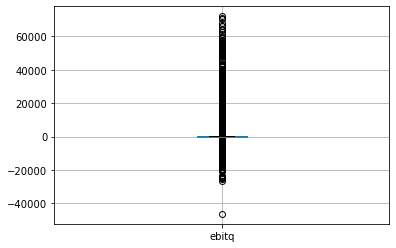

In [6]:
# Checking for outliers in quarterly EBIT.
df_ready.boxplot(column = ['ebitq'])

In [7]:
# Checking for variance in means between different features.
print(df_ready.revtq.describe())
print("")
print(df_ready.txpq.describe())

count    273477.000000
mean       2597.359849
std       10796.375915
min        -219.205000
25%         101.204000
50%         370.927000
75%        1378.864000
max      455088.000000
Name: revtq, dtype: float64

count    273477.000000
mean         33.794102
std         232.776385
min        -103.268000
25%           0.000000
50%           0.205000
75%           6.717000
max       15663.000000
Name: txpq, dtype: float64


In [8]:
# Printing TSLA stock to check if data is correct.
df_mfill[['datadate', 'cusip', 'prccq_adj']].loc[df_mfill['cusip'] == '88160R101']

,datadate,cusip,prccq_adj
615490,2010-06-30,88160R101,4.7660
615491,2010-09-30,88160R101,4.0810
615492,2010-12-31,88160R101,5.3260
615493,2011-03-31,88160R101,5.5500
615494,2011-06-30,88160R101,5.8260
615495,2011-09-30,88160R101,4.8780
615496,2011-12-31,88160R101,5.7120
615497,2012-03-31,88160R101,7.4480
615498,2012-06-30,88160R101,6.2580
615499,2012-09-30,88160R101,5.8560


In [9]:
# Scaling all input time-steps by market cap of last input time step.
df_ready = df_ready[df_ready.mrkcapq != 0]

for col in X_col_list_fundamentals:
    df_ready.loc[:,col] = df_ready.loc[:,col]/df_ready.loc[:,'mrkcapq']

for col in y_col_list:
    df_ready.loc[:,col] = df_ready.loc[:,col]/df_ready.loc[:,'mrkcapq']

In [10]:
# Dropping inf, -inf and NaN values.
df_ready.replace([np.inf, -np.inf], np.nan, inplace=True)
df_ready = df_ready.dropna()
df_ready.shape

(273315, 138)

In [11]:
# Splitting dataframe into train (+val) and test sets.
df_train_val = df_ready[(df_ready.datadate >= datetime(1970, 1, 1)) & (df_ready.datadate <= datetime(1999, 12, 31))]
df_test = df_ready[(df_ready.datadate >= datetime(2000, 1, 1)) & (df_ready.datadate <= datetime(2016, 12, 31))]

In [12]:
# Splitting train + val set into train set and val set.
splitter = GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 7)
split = splitter.split(df_train_val, groups=df_train_val['cusip'])
train_inds, test_inds = next(split)

df_train = df_train_val.iloc[train_inds]
df_val = df_train_val.iloc[test_inds]

In [13]:
# Checking distribution of unique stocks.
print(df_train_val['cusip'].nunique())
print(df_train['cusip'].nunique() + df_val['cusip'].nunique())

3786
3786


In [14]:
# Splitting dataframes into X and y dataframes.
X_train = df_train.filter(X_col_list)
y_train = df_train.filter(y_col_list)
X_val = df_val.filter(X_col_list)
y_val = df_val.filter(y_col_list)
X_test = df_test.filter(X_col_list)
y_test = df_test.filter(y_col_list)

In [15]:
# Scaling all features to have zero mean and unit standard deviation.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_val = scaler.fit_transform(y_val)
y_test = scaler.fit_transform(y_test)

In [16]:
# Saving all dataframes needed for modeling as pickle files.
df = [[X_train, X_val, X_test, y_train, y_val, y_test], ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test']]
for i in range(len(df[0])):
    name = str()
    pd.DataFrame(df[0][i]).to_pickle("./" + str(df[1][i]) + ".pkl")

In [17]:
# Checking size of final dataframes.
print(pd.DataFrame(y_train).shape)
print(pd.DataFrame(X_val).shape)
print(pd.DataFrame(X_test).shape)

(86351, 16)
(39365, 100)
(147594, 100)
